In [88]:
import numpy as np
import random
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

In [89]:
# Test fonksiyonu:
def f(w):
    return 0.5 * (w[0]**2 + 1e-6 * w[1]**2)

def grad(w):
    return np.array([w[0], 1e-6 * w[1]], dtype=float)

# başlangıç noktası
w0 = np.array([1.0, 1.0], dtype=float)

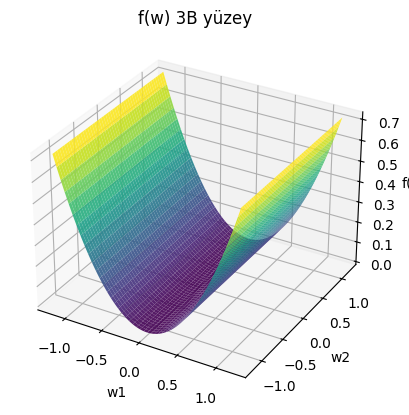

In [98]:
from mpl_toolkits.mplot3d import Axes3D

w1_min, w1_max = -1.2, 1.2
w2_min, w2_max = -1.2, 1.2
n = 300

W1, W2 = np.meshgrid(np.linspace(w1_min, w1_max, n),
                     np.linspace(w2_min, w2_max, n))
F = 0.5 * (W1**2 + 1e-6 * W2**2)

fig = plt.figure(figsize=(6, 4.8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, F, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_title("f(w) 3B yüzey")
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.set_zlabel("f(w)")
plt.show()

In [90]:
class AdamBase:
    def __init__(self, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None
        self.v = None
        self.t = 0

    def step(self, w, g):
        if self.m is None:
            self.m = np.zeros_like(w)
            self.v = np.zeros_like(w)

        self.t += 1
        b1, b2 = self.beta1, self.beta2

        # momentler
        self.m = b1 * self.m + (1 - b1) * g
        self.v = b2 * self.v + (1 - b2) * (g * g)

        # bias correction
        m_hat = self.m / (1 - b1**self.t)
        v_hat = self.v / (1 - b2**self.t)

        update = self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        return w - update


class Adam_S1:
    """
    değişiklik 1:
    hedef: çok küçük v_hat -> alt sınır koyup küçük gradientlerin gereksiz
    büyümesini engellemek.
    """
    def __init__(self, lr=1e-2, beta1=0.9, beta2=0.999,
                 eps=1e-8, vmin=1e-3):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.vmin = vmin
        self.m = None
        self.v = None
        self.t = 0

    def step(self, w, g):
        if self.m is None:
            self.m = np.zeros_like(w)
            self.v = np.zeros_like(w)

        self.t += 1
        b1, b2 = self.beta1, self.beta2

        self.m = b1 * self.m + (1 - b1) * g
        self.v = b2 * self.v + (1 - b2) * (g * g)

        m_hat = self.m / (1 - b1**self.t)
        v_hat = self.v / (1 - b2**self.t)

        denom = np.sqrt(v_hat) + self.eps
        # alt sınır
        denom = np.maximum(denom, self.vmin)

        update = self.lr * m_hat / denom
        return w - update


class Adam_S2:
    """
    değişiklik 2:
    hedef: v_hat çok küçükse o boyutta Adam kullanmayıp düz SGD adımı atmak.
    Küçük-gradient yönlerinde Adam'ın "şişirme" etkisini kapatmayı hedefliyor.
    """
    def __init__(self, lr=1e-2, beta1=0.9, beta2=0.999,
                 eps=1e-8, v_thresh=1e-6):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.v_thresh = v_thresh
        self.m = None
        self.v = None
        self.t = 0

    def step(self, w, g):
        if self.m is None:
            self.m = np.zeros_like(w)
            self.v = np.zeros_like(w)

        self.t += 1
        b1, b2 = self.beta1, self.beta2

        self.m = b1 * self.m + (1 - b1) * g
        self.v = b2 * self.v + (1 - b2) * (g * g)

        m_hat = self.m / (1 - b1**self.t)
        v_hat = self.v / (1 - b2**self.t)

        update = np.zeros_like(w)

        for i in range(len(w)):
            if v_hat[i] < self.v_thresh:
                # Bu boyutta Adam'a güvenmiyorum, düz gradient kullan
                update[i] = self.lr * g[i]
            else:
                update[i] = self.lr * m_hat[i] / (np.sqrt(v_hat[i]) + self.eps)

        return w - update

In [91]:
def run_opt(OptClass, name, steps=200, **kwargs):
    w = w0.copy()
    opt = OptClass(**kwargs)
    traj = [w.copy()]
    for t in range(steps):
        g = grad(w)
        w = opt.step(w, g)
        traj.append(w.copy())
    traj = np.array(traj)
    print(f"{name}: final w = {traj[-1]}, f(w) = {f(traj[-1]):.6e}")
    return traj

In [92]:
steps = 200

traj_adam = run_opt(
    AdamBase,
    "AdamBase",
    steps=steps,
    lr=1e-2
)

traj_floor = run_opt(
    Adam_S1,
    "Adam_S1",
    steps=steps,
    lr=1e-2,
    vmin=1e-3
)

traj_switch = run_opt(
    Adam_S2,
    "Adam_S2",
    steps=steps,
    lr=1e-2,
    v_thresh=1e-6
)

AdamBase: final w = [0.01557249 0.01767338], f(w) = 1.212513e-04
Adam_S1: final w = [0.01557249 0.99800182], f(w) = 1.217492e-04
Adam_S2: final w = [0.01557249 0.999998  ], f(w) = 1.217512e-04


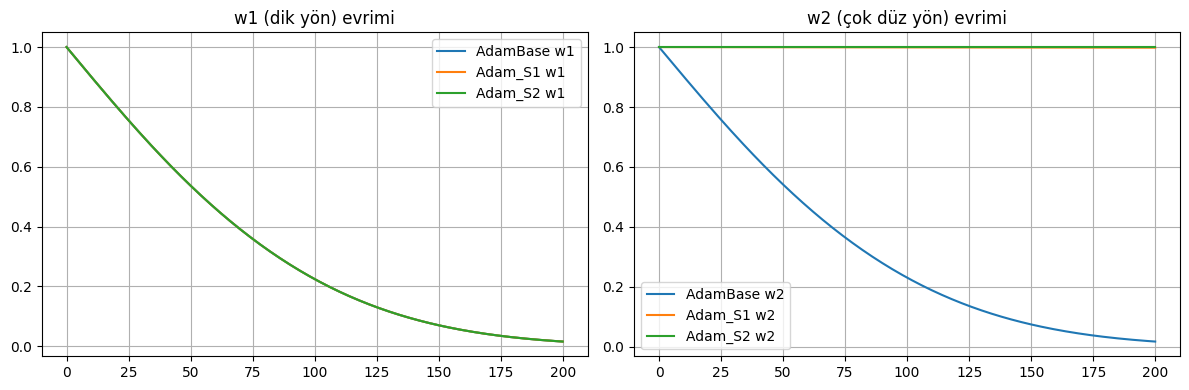

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

# Sol: w1 (dik yön)
axes[0].plot(traj_adam[:,0], label="AdamBase w1")
axes[0].plot(traj_floor[:,0], label="Adam_S1 w1")
axes[0].plot(traj_switch[:,0], label="Adam_S2 w1")
axes[0].set_title("w1 (dik yön) evrimi")
axes[0].legend()
axes[0].grid(True)

# Sağ: w2 (çok düz yön)
axes[1].plot(traj_adam[:,1], label="AdamBase w2")
axes[1].plot(traj_floor[:,1], label="Adam_S1 w2")
axes[1].plot(traj_switch[:,1], label="Adam_S2 w2")
axes[1].set_title("w2 (çok düz yön) evrimi")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [94]:
## min değer değişimi

In [95]:
# optimizerları çalıştır
steps = 200

traj_adam = run_opt(
    AdamBase,
    "AdamBase",
    steps=steps,
    lr=1e-2
)

traj_floor = run_opt(
    Adam_S1,
    "Adam_S1",
    steps=steps,
    lr=1e-2,
    vmin=1e-3
)

traj_switch = run_opt(
    Adam_S2,
    "Adam_S2",
    steps=steps,
    lr=1e-2,
    v_thresh=1e-6
)

AdamBase: final w = [0.01557249 0.01767338], f(w) = 1.212513e-04
Adam_S1: final w = [0.01557249 0.99800182], f(w) = 1.217492e-04
Adam_S2: final w = [0.01557249 0.999998  ], f(w) = 1.217512e-04


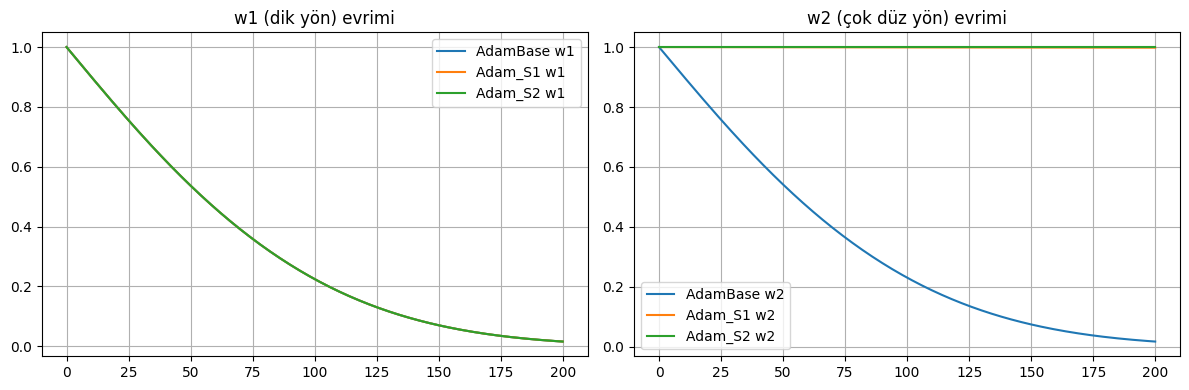

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

# Sol: w1 (dik yön)
axes[0].plot(traj_adam[:,0], label="AdamBase w1")
axes[0].plot(traj_floor[:,0], label="Adam_S1 w1")
axes[0].plot(traj_switch[:,0], label="Adam_S2 w1")
axes[0].set_title("w1 (dik yön) evrimi")
axes[0].legend()
axes[0].grid(True)

# Sağ: w2 (çok düz yön)
axes[1].plot(traj_adam[:,1], label="AdamBase w2")
axes[1].plot(traj_floor[:,1], label="Adam_S1 w2")
axes[1].plot(traj_switch[:,1], label="Adam_S2 w2")
axes[1].set_title("w2 (çok düz yön) evrimi")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
